# Final Project Submission

* Student name: Nastaran Nazemian
* Student pace: part time
* Scheduled project review date/time: 10/19/2020 11:00PM (PS)
* Instructor name: Lindsey Berlin
* Blog post URL:

# Table of Contents

1. [Introduction](#intro)
    
2. [Gather and Scrape the Data](#gather)

3. [Data Exploration](#explore)

4. [Modelling Data](#model)

5. [Conclusions](#con)

6. [Future Work](#futur)
   
   

## 1.Introduction: <a class="anchor" id="intro"></a>

Recommending people to buy what they think they need or near to what they used to use in past is one of the most effective way to encourage people to buy more. A recommender system, or a recommendation system is one of the ways that seeks to predict the "rating" or "preference" a user would give to an item.

This thickness is utilized in a variety of areas such as playlist generators for video and music services like MovieLens, that helps you find movies you will like. Rate movies to build a custom taste profile, then MovieLens recommends other movies for you to watch.

The dataset that I have used in this project is from a movie recommendation service, MovieLens. This dataset contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.


### Import Libraries


In [1]:
#import libraries
import zipfile
import glob
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings(action="ignore", message="unclosed", category=ResourceWarning)
# For merging 3 dataframe
import re
from functools import reduce

from surprise import Reader, Dataset
from surprise.model_selection import train_test_split, GridSearchCV
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy
from surprise.prediction_algorithms import knns, SVD

# from pyspark.sql import SparkSession
# spark = SparkSession.builder.appName('Recommendation_system').getOrCreate()

from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

## 2.Gather and Scrape the Data: <a class="anchor" id="gather"></a>

In this part, I am going to unzip the data file, check the data frames for missing data, and add the year column to the merged data set.

In [2]:
# read zip file
with zipfile.ZipFile("ml-latest-small.zip","r") as zip_ref:
    zip_ref.extractall()
    
# pull csv file
txtfiles = []
for file in glob.glob('C:/Flatiron/course-material/ModuleFourFinalProject/Recommendation/ml-latest-small/*.csv'):
    txtfiles.append(file)
txtfiles 

# Load each csv files into a dataframe
ratings_df = pd.read_csv("ml-latest-small/ratings.csv")
movies_df = pd.read_csv("ml-latest-small/movies.csv")


In [3]:
# print each rating dataframe and look at the info
print(ratings_df.info())
ratings_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
# print each movies dataframe and look at the info
print(movies_df.info())
movies_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
# drop timestamp columns from ratings and tags
ratings_df.drop(columns=['timestamp'], inplace=True)


In [6]:
# print number of the rows and columns od the ratings and movies dataframes
print('ratings_df:', ratings_df.shape,' ','columns_name:',ratings_df.columns)
print('movies_df:', movies_df.shape,' ','columns_name:',movies_df.columns )

ratings_df: (100836, 3)   columns_name: Index(['userId', 'movieId', 'rating'], dtype='object')
movies_df: (9742, 3)   columns_name: Index(['movieId', 'title', 'genres'], dtype='object')


In [7]:
# merging the dataframes 
df = pd.merge(movies_df, ratings_df)
df.shape
df.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5


In [8]:
# lokk at the dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   movieId  100836 non-null  int64  
 1   title    100836 non-null  object 
 2   genres   100836 non-null  object 
 3   userId   100836 non-null  int64  
 4   rating   100836 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.6+ MB


In [9]:
df.isna().sum()

movieId    0
title      0
genres     0
userId     0
rating     0
dtype: int64

In [10]:
df = df.loc[df.genres !='(no genres listed)'] 
df.shape

(100789, 5)

In [11]:
#define functions for creating year column, title no year column, and plot
#import re
p = re.compile("([0-9]{4})")
def Movie_Year(title_str):
    result = p.search(title_str)
    if result:
        a = float(result.group())
    else:
        a = float("nan")
    return a

l = re.compile("([a-zA-Z, ]*)")

def Title_NoYear(title_str):
    result = p.search(title_str)
    if result:
        result1 = l.search(title_str)
        a = result1.group(1)
    else:
        a = title_str
    return a

def plot_func(title,x_axes, y_axes,data_df, color ):
    f, ax = plt.subplots(figsize=(20,10))
    sns.set(style="whitegrid")
    ax.set_title(title, y=1.2, fontsize=20, ha='center').set_position([0.5,1.08])
    ax = sns.barplot(x=x_axes, y=y_axes , data= data_df, palette=color)

In [12]:
#creat year column
df['year'] =list(map(lambda x: Movie_Year(x), df.title))
df['year'] = df['year'].astype('Int64')

#creat no_year_title
df['no_year_title'] =list(map(lambda x: Title_NoYear(x), df.title))
df['no_year_title'].head()

0    Toy Story 
1    Toy Story 
2    Toy Story 
3    Toy Story 
4    Toy Story 
Name: no_year_title, dtype: object

In [13]:
df = df.loc[df.no_year_title !='']
df.shape

(99195, 7)

In [14]:
df.head()

,movieId,title,genres,userId,rating,year,no_year_title
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,1995,Toy Story
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,1995,Toy Story
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1995,Toy Story
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1995,Toy Story
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1995,Toy Story


In [15]:
# find number of the missing values for each column
df.isna().sum()

movieId          0
title            0
genres           0
userId           0
rating           0
year             8
no_year_title    0
dtype: int64

In [16]:
df.loc[df.year.isna()]

,movieId,title,genres,userId,rating,year,no_year_title
81292,40697,Babylon 5,Sci-Fi,210,4.0,<NA>,Babylon 5
81293,40697,Babylon 5,Sci-Fi,528,0.5,<NA>,Babylon 5
99325,140956,Ready Player One,Action|Sci-Fi|Thriller,209,3.5,<NA>,Ready Player One
99326,140956,Ready Player One,Action|Sci-Fi|Thriller,305,4.5,<NA>,Ready Player One
99327,140956,Ready Player One,Action|Sci-Fi|Thriller,380,3.0,<NA>,Ready Player One
99328,140956,Ready Player One,Action|Sci-Fi|Thriller,514,3.0,<NA>,Ready Player One
99617,149334,Nocturnal Animals,Drama|Thriller,306,3.0,<NA>,Nocturnal Animals
100051,162414,Moonlight,Drama,462,5.0,<NA>,Moonlight


In [17]:
df.year.sort_values(ascending=True).unique()

<IntegerArray>
[1000, 1138, 1600, 1900, 1902, 1903, 1908, 1915, 1916, 1917,
 ...
 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2049, 3000, <NA>]
Length: 113, dtype: Int64

In [18]:
df.dtypes

movieId            int64
title             object
genres            object
userId             int64
rating           float64
year               Int64
no_year_title     object
dtype: object

## 3.Data Exploration: <a class="anchor" id="explore"></a>

In this section, I am going to do some analysis on the data and use visual exploration to understand better the characteristics of data. 

Text(0.5, 0, 'Year')

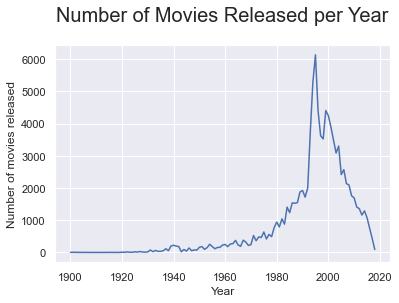

In [19]:
#create a data frame for movies are between 1899 through 2020
year_df = df.loc[(df.year >1899) & (df.year < 2020)]
year_df.year.sort_values().unique()
#len(year_df.year.unique())


df_movie_year = year_df.groupby('year').agg({'year': 'count'})
df_movie_year.rename(columns={'year': 'year_count'}, inplace = True)
df_movie_year = df_movie_year.reset_index()
sns.set_theme(style="darkgrid")

#Plot the number of the movies relesed per year
ax =sns.lineplot(x="year", y="year_count", data=df_movie_year)
ax.set_title("Number of Movies Released per Year", y=1.2, fontsize=20, ha='center').set_position([0.5,1.08])
ax.set_ylabel('Number of movies released')
ax.set_xlabel('Year')

As shown the graph above, the number of the movies released in 1995 (6,141 movies released) in our data is the largest.

In [20]:
df_movie_year.sort_values(by='year_count', ascending=False, inplace=True)
df_movie_year


,year,year_count
83,1995,6141
82,1994,5290
84,1996,4413
87,1999,4409
88,2000,4247
...,...,...
2,1903,2
7,1919,1
6,1917,1
4,1915,1


Let’s look at the movies genera and how they have distributed in our data. For this reason, first I fam going to flatten my data since each element of the genera column is a list of several genres. 

In [21]:
#Split the a movie genres
df1 = df.copy()
df1['genres'] = df['genres'].str.split('|')

#creat a flattent dataframe
flatten_df = df1['genres'].apply(pd.Series) \
        .merge(df, right_index = True, left_index = True) \
        .drop(['genres'], axis = 1) \
        .melt(id_vars = df.columns.drop('genres'), value_name = "genres") \
        .drop("variable", axis = 1) \
        .dropna(subset=['genres'])

print(flatten_df.genres.unique())
print(flatten_df.shape)

['Adventure' 'Comedy' 'Action' 'Drama' 'Crime' 'Children' 'Mystery'
 'Animation' 'Documentary' 'Thriller' 'Horror' 'Fantasy' 'Western'
 'Film-Noir' 'Romance' 'Sci-Fi' 'Musical' 'War' 'IMAX']
(270418, 7)


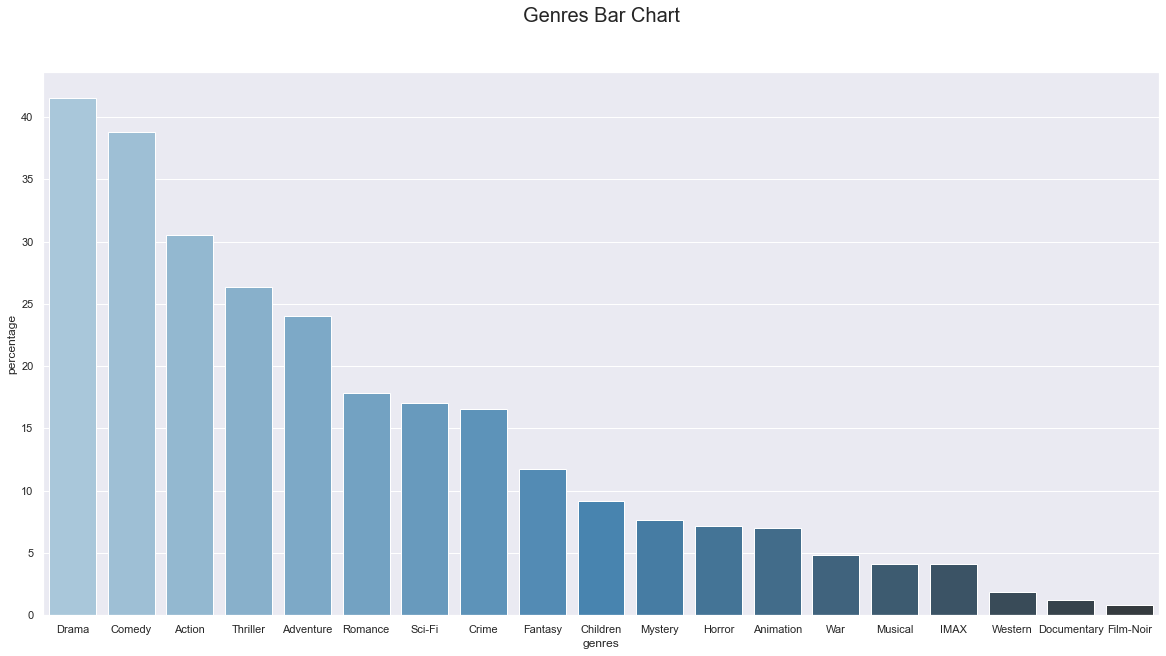

In [22]:
flatten_df = flatten_df.loc[(flatten_df.year >1899) & (flatten_df.year < 2020)]
genres_df = flatten_df.groupby('genres').agg({'genres': 'count'})
genres_df['percentage'] = round(genres_df['genres'] * 100 / df.shape[0],2)
genres_df.rename(columns={'genres': 'genres_count'}, inplace = True)
genres_df = genres_df.reset_index()
genres_df.sort_values(by='percentage', ascending=False, inplace=True)
genres_df.head()
plot_func('Genres Bar Chart','genres', 'percentage', genres_df,"Blues_d" )

In [23]:
genres_df

,genres,genres_count,percentage
7,Drama,41224,41.56
4,Comedy,38451,38.76
0,Action,30258,30.50
16,Thriller,26139,26.35
1,Adventure,23840,24.03
14,Romance,17731,17.87
15,Sci-Fi,16864,17.00
5,Crime,16455,16.59
8,Fantasy,11659,11.75
3,Children,9086,9.16


According to the Genres Bar Chart, more than 41%, of the movies have drama genera. After drama, comedy, Action and thriller have the highest percentage among the others.

In the next plot, I am going to consider the trend of each movie genrea during the 1899 through 2020. 

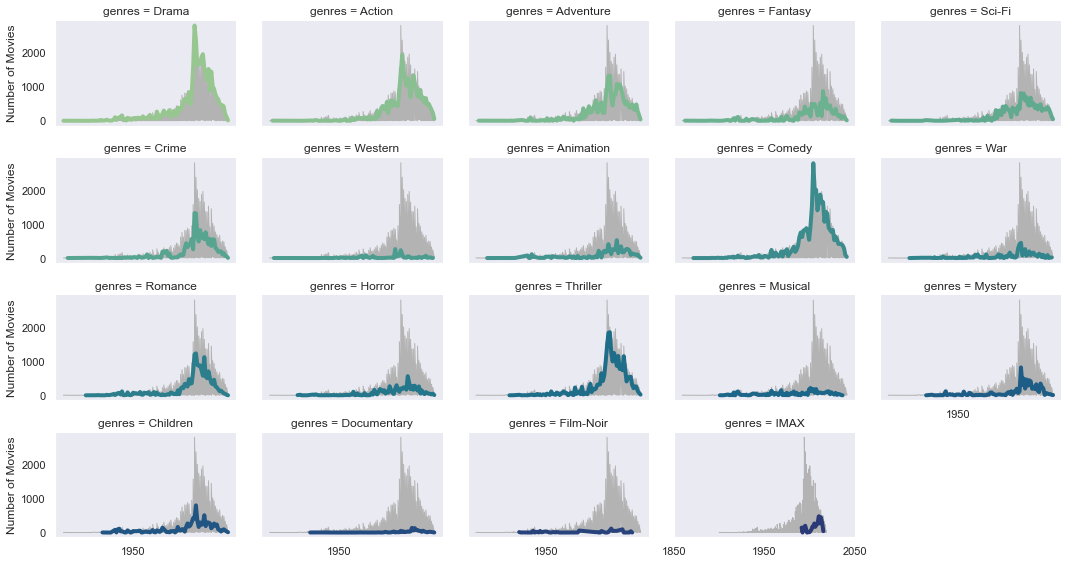

In [24]:
sns.set_theme(style="dark")
new_df = flatten_df.groupby(['year','genres']).agg({'year': 'count'})
new_df.rename(columns={'year': 'year_count'}, inplace = True)
new_df = new_df.reset_index()
new_df.genres.unique()
# Plot each year's time series in its own facet
g = sns.relplot(
    data=new_df,
    x="year", y="year_count", col="genres",hue="genres", 
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=5, height=2, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    #ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=new_df, x="year", y="year_count", 
        estimator=None, color=".7", linewidth=1, ax=ax,
    )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
#g.ax.set_title("Yearly Movie Production count by Genrea ")
g.set_axis_labels("", 'Number of Movies')
g.tight_layout()

As you can see in above, the number of the movies in our dataset for Western, Musical, Documentary and Film-Nori genera are consistent during 1899 through 2020. While the distribution of the number of movies in our data for other genres is skewed to left.   

In below I am going to illustrate the average rating count per genera.  

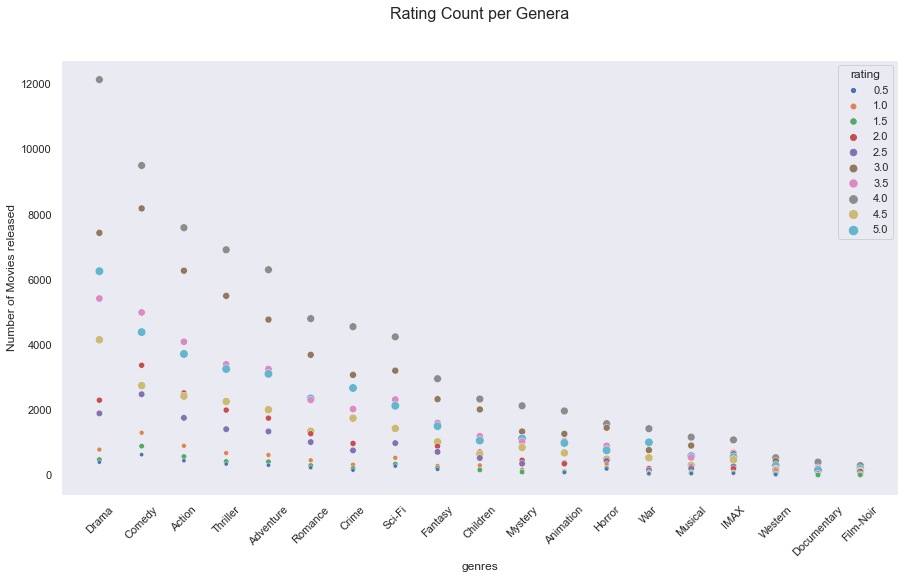

In [25]:
#Plo Rating Count per Genera
ave_rating_df = flatten_df.groupby(['genres','rating']).agg({'movieId': 'count'})
ave_rating_df = ave_rating_df.reset_index()
ave_rating_df.sort_values(by='movieId', ascending=False, inplace=True)


plt.figure(figsize=(15,8))

chart = sns.scatterplot(x = ave_rating_df.genres, y = ave_rating_df.movieId,
                        hue=ave_rating_df.rating, hue_norm=(0, 7), legend="full"
                        , palette="deep", size=ave_rating_df.rating)

plt.setp(chart.get_xticklabels(), rotation=45)
chart.set_title("Rating Count per Genera", y=1.2, fontsize=16, ha='center').set_position([0.5,1.08])
chart.set_ylabel('Number of Movies released')

plt.show()

As the plot in above shows, in most of the genres the number of the movies have rating 4 and 3.2 is more than movies with other ratings. 



In [26]:
# Which movie has more rating count among the users? 
df_title = df.groupby('title').agg({'rating': 'count'}).sort_values(by='rating', ascending=False)
df_title = df_title.reset_index()
# plot_func('Number of Rating per Movies','title', 'rating', df_title[:6], 'Set2' )

In [27]:
df_title.head(20)

,title,rating
0,Forrest Gump (1994),329
1,"Shawshank Redemption, The (1994)",317
2,Pulp Fiction (1994),307
3,"Silence of the Lambs, The (1991)",279
4,"Matrix, The (1999)",278
5,Star Wars: Episode IV - A New Hope (1977),251
6,Jurassic Park (1993),238
7,Braveheart (1995),237
8,Terminator 2: Judgment Day (1991),224
9,Schindler's List (1993),220


In [28]:
df_title.title.unique()

array(['Forrest Gump (1994)', 'Shawshank Redemption, The (1994)',
       'Pulp Fiction (1994)', ...,
       'Kizumonogatari Part 1: Tekketsu (2016)',
       'Kizumonogatari III: Cold Blood (2017)', 'Last Legion, The (2007)'],
      dtype=object)

The folowing plot shows the most common ratings are 4 and 3.

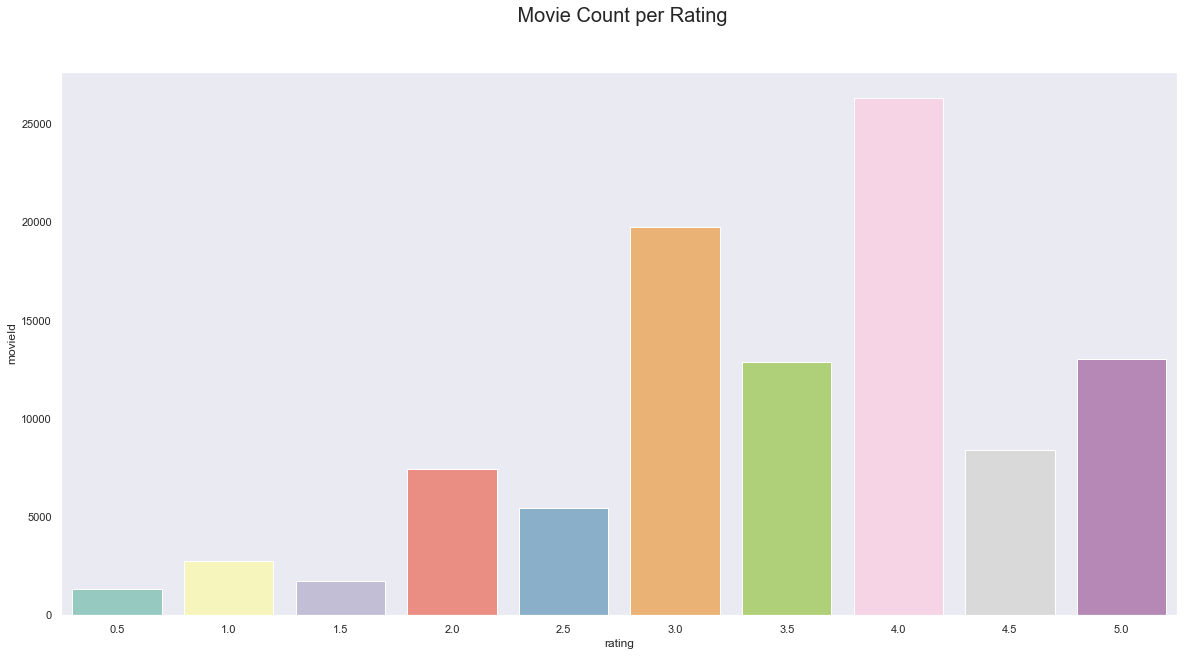

In [29]:
df_rating = df.groupby('rating').agg({'movieId': 'count'}).sort_values(by='rating', ascending=False)
df_rating = df_rating.reset_index()
plot_func(' Movie Count per Rating','rating', 'movieId', df_rating,'Set3' )

## Modelling Data:<a class="anchor" id="model"></a>
Surprise is a Python library that was created for building and analyzing recommendation systems for rating data. There are several points for using Surprise library:

* Give users perfect control over their experiments.
* Users can built-in datasets, or their own custom datasets. 
* In this library, there are various ready-to-use prediction algorithms and similarity measures such as baseline algorithms, neighborhood methods, matrix factorization-based, Cosine, MSD, and Pearson.
* Make it easy to implement new algorithm ideas.
* There are various tools for evaluating, analyzing, and compare the algorithms.

[Supriselib](http://surpriselib.com/)

In [30]:
reader = Reader()
data = Dataset.load_from_df(ratings_df, reader)
dataset = data.build_full_trainset()

In [31]:
type(dataset)

surprise.trainset.Trainset

In [32]:
print(dataset.n_users)
print(dataset.n_items)
print(dataset.n_ratings)

610
9724
100836


In [33]:
trainset, testset = train_test_split(data, test_size=0.2)
print(len(testset))
print(testset[0])

20168
(391, 2948, 4.0)


In [34]:
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  610 

Number of items:  8989 



In this part I am going to find the best algorithms among KNNBasic, KNNBaseline, KNNWithMeans, KNNWithZScore, and SVD.

In [35]:
#Optimized SVD
svd_grid = {'reg_all': [ 0.15, 0.25],
            'n_epochs':[ 70, 110],
            'lr_all': [0.05, 0.01], 
            'random_state': [123]}

filtering_option = GridSearchCV(SVD, param_grid = svd_grid, n_jobs=-1)
filtering_option .fit(data)
print(filtering_option.best_score)
print(filtering_option.best_params)

{'rmse': 0.8544900828751125, 'mae': 0.6552545607631246}
{'rmse': {'reg_all': 0.15, 'n_epochs': 110, 'lr_all': 0.01, 'random_state': 123}, 'mae': {'reg_all': 0.15, 'n_epochs': 110, 'lr_all': 0.01, 'random_state': 123}}


In [36]:
knnbasic = knns.KNNBasic
knnbaseline = knns.KNNBaseline
knnwithmeans = knns.KNNWithMeans
knnwithzscore = knns.KNNWithZScore
svd = SVD
rmse_scores = {}
# optimized KNN gridsearch
knn_grid = {'sim_options': {'name': ['cosine', 'pearson', 'MSD', 'pearson_baseline'], \
                        'user_based': [True, False]},
            'random_state': [123]}

# SVD gridsearch with best_params

svd_grid = {'reg_all': [0.15],
            'n_epochs':[110],
            'lr_all': [0.01], 
            'random_state': [123]}

def Knn_svd_function(filtering_option, param_grid, data_set):
    """This function has 3 inputs: collaborative filtering method's name, 
    parameter grid, and dataset. It will then perform a gridsearch using 
    cross validation to create an optimal prediction model. The model will 
    then be scored using RMSE and MAE, and will return the scores with the 
    optimal parameters."""

    filtering_option = GridSearchCV(filtering_option, param_grid = param_grid, n_jobs=-1)
    filtering_option.fit(data_set)
    print(filtering_option)
    print(filtering_option.best_score)
    print(filtering_option.best_params)
    return (filtering_option.best_score, filtering_option.best_params)

In [44]:
# rmse_scores['knnbasic'] = Knn_svd_function(knnbasic, knn_grid, data)  
# rmse_scores['knnbaseline'] = Knn_svd_function(knnbaseline, knn_grid, data)    
# rmse_scores['knnwithmeans'] = Knn_svd_function(knnwithmeans, knn_grid, data) 
# rmse_scores['knnwithzscore'] = Knn_svd_function(knnwithzscore, knn_grid, data)    
# rmse_scores['svd'] = Knn_svd_function(svd, svd_grid, data)

{'rmse': 0.9081292199147215, 'mae': 0.6955361086637195}
{'rmse': {'sim_options': {'name': 'MSD', 'user_based': False}, 'random_state': 123}, 'mae': {'sim_options': {'name': 'pearson_baseline', 'user_based': False}, 'random_state': 123}}
{'rmse': 0.8518339579931252, 'mae': 0.6499539956316573}
{'rmse': {'sim_options': {'name': 'pearson_baseline', 'user_based': False}, 'random_state': 123}, 'mae': {'sim_options': {'name': 'pearson_baseline', 'user_based': False}, 'random_state': 123}}
{'rmse': 0.883029080541571, 'mae': 0.6710764755345708}
{'rmse': {'sim_options': {'name': 'pearson_baseline', 'user_based': False}, 'random_state': 123}, 'mae': {'sim_options': {'name': 'pearson_baseline', 'user_based': False}, 'random_state': 123}}
{'rmse': 0.8846762410158202, 'mae': 0.6709006253614715}
{'rmse': {'sim_options': {'name': 'pearson_baseline', 'user_based': False}, 'random_state': 123}, 'mae': {'sim_options': {'name': 'pearson_baseline', 'user_based': True}, 'random_state': 123}}
{'rmse': 0.8542

According to above, knnbaseline modeling with Pearson baseline measure method and user_based = False is better than other models since we have the less RMSE and MAE.

In [38]:
rec_model = knns.KNNBaseline(sim_option={'name': 'pearson_baseline', 'user_based': False}, random_state=123)
train_model=rec_model.fit(trainset)
predictions = rec_model.test(testset)


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [103]:
def name_movies(movie_id, movie_title_df):
    return movie_title_df['title'].loc[movie_title_df.movieId == movie_id].values

In [94]:
# movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [102]:
# print(movies_df['title'].loc[movies_df['movieId']==2324])
# print(name_movies(318, movies_df).values)

['Shawshank Redemption, The (1994)']


In [41]:
from collections import defaultdict
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [61]:
top_n = get_top_n(predictions, n=2)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [name_movies(iid, movies_df) for (iid, _) in user_ratings])


391 [796    Secrets & Lies (1996)
Name: title, dtype: object, 914    Goodfellas (1990)
Name: title, dtype: object]
328 [2462    Boondock Saints, The (2000)
Name: title, dtype: object, 224    Star Wars: Episode IV - A New Hope (1977)
Name: title, dtype: object]
438 [1939    Matrix, The (1999)
Name: title, dtype: object, 2226    Fight Club (1999)
Name: title, dtype: object]
599 [7611    Tree of Life, The (2011)
Name: title, dtype: object, 6117    Project A ('A' gai waak) (1983)
Name: title, dtype: object]
422 [982    High Noon (1952)
Name: title, dtype: object, 949    Bridge on the River Kwai, The (1957)
Name: title, dtype: object]
58 [254    Léon: The Professional (a.k.a. The Professiona...
Name: title, dtype: object, 257    Pulp Fiction (1994)
Name: title, dtype: object]
91 [4661    Devil's Playground (2002)
Name: title, dtype: object, 2786    Near Dark (1987)
Name: title, dtype: object]
440 [935    Harold and Maude (1971)
Name: title, dtype: object, 706    2001: A Space Odyssey (1968)

314 [461    Schindler's List (1993)
Name: title, dtype: object, 965    Unforgiven (1992)
Name: title, dtype: object]
219 [2226    Fight Club (1999)
Name: title, dtype: object, 922    Godfather: Part II, The (1974)
Name: title, dtype: object]
43 [842    Children of the Corn IV: The Gathering (1996)
Name: title, dtype: object, 217    Interview with the Vampire: The Vampire Chroni...
Name: title, dtype: object]
379 [461    Schindler's List (1993)
Name: title, dtype: object, 32    Babe (1995)
Name: title, dtype: object]
372 [461    Schindler's List (1993)
Name: title, dtype: object, 899    Princess Bride, The (1987)
Name: title, dtype: object]
534 [8565    Dead Snow 2: Red vs. Dead (2014) 
Name: title, dtype: object, 7182    Battlestar Galactica: The Plan (2009)
Name: title, dtype: object]
249 [883    Paths of Glory (1957)
Name: title, dtype: object, 7180    Fantastic Mr. Fox (2009)
Name: title, dtype: object]
51 [2131    Outside Providence (1999)
Name: title, dtype: object, 903    Good, t

98 [899    Princess Bride, The (1987)
Name: title, dtype: object, 3984    Spirited Away (Sen to Chihiro no kamikakushi) ...
Name: title, dtype: object]
188 [695    Maltese Falcon, The (1941)
Name: title, dtype: object, 707    All About Eve (1950)
Name: title, dtype: object]
387 [4694    Last Tango in Paris (Ultimo tango a Parigi) (1...
Name: title, dtype: object, 5230    Day at the Races, A (1937)
Name: title, dtype: object]
382 [8104    21 and Over (2013)
Name: title, dtype: object, 277    Shawshank Redemption, The (1994)
Name: title, dtype: object]
313 [706    2001: A Space Odyssey (1968)
Name: title, dtype: object, 920    Psycho (1960)
Name: title, dtype: object]
318 [9489    Mulholland Dr. (1999)
Name: title, dtype: object, 7811    All Watched Over by Machines of Loving Grace (...
Name: title, dtype: object]
123 [510    Silence of the Lambs, The (1991)
Name: title, dtype: object, 257    Pulp Fiction (1994)
Name: title, dtype: object]
302 [659    Godfather, The (1972)
Name: title, d

564 [6676    In Bruges (2008)
Name: title, dtype: object, 1445    Breakfast Club, The (1985)
Name: title, dtype: object]
550 [8376    Interstellar (2014)
Name: title, dtype: object, 8475    Guardians of the Galaxy (2014)
Name: title, dtype: object]
342 [900    Raiders of the Lost Ark (Indiana Jones and the...
Name: title, dtype: object, 1872    Payback (1999)
Name: title, dtype: object]
180 [960    Evil Dead II (Dead by Dawn) (1987)
Name: title, dtype: object, 863    Monty Python and the Holy Grail (1975)
Name: title, dtype: object]
275 [2524    Taking of Pelham One Two Three, The (1974)
Name: title, dtype: object, 796    Secrets & Lies (1996)
Name: title, dtype: object]
450 [1472    Exorcist, The (1973)
Name: title, dtype: object, 2641    American Psycho (2000)
Name: title, dtype: object]
137 [686    Rear Window (1954)
Name: title, dtype: object, 937    Seventh Seal, The (Sjunde inseglet, Det) (1957)
Name: title, dtype: object]
462 [982    High Noon (1952)
Name: title, dtype: object, 

Name: title, dtype: object]
10 [7467    Tangled (2010)
Name: title, dtype: object, 4812    Chasing Liberty (2004)
Name: title, dtype: object]
357 [951    Chinatown (1974)
Name: title, dtype: object, 314    Forrest Gump (1994)
Name: title, dtype: object]
186 [680    Philadelphia Story, The (1940)
Name: title, dtype: object, 681    Singin' in the Rain (1952)
Name: title, dtype: object]
77 [3141    Memento (2000)
Name: title, dtype: object, 5917    Batman Begins (2005)
Name: title, dtype: object]
368 [659    Godfather, The (1972)
Name: title, dtype: object, 2877    Easy Money (1983)
Name: title, dtype: object]
447 [254    Léon: The Professional (a.k.a. The Professiona...
Name: title, dtype: object, 508    Dances with Wolves (1990)
Name: title, dtype: object]
518 [1304    Wag the Dog (1997)
Name: title, dtype: object]
83 [4137    Lord of the Rings: The Two Towers, The (2002)
Name: title, dtype: object, 901    Brazil (1985)
Name: title, dtype: object]
383 [2078    Sixth Sense, The (1999)
Na

553 [613    Trainspotting (1996)
Name: title, dtype: object, 257    Pulp Fiction (1994)
Name: title, dtype: object]
512 [461    Schindler's List (1993)
Name: title, dtype: object, 314    Forrest Gump (1994)
Name: title, dtype: object]
22 [6315    Departed, The (2006)
Name: title, dtype: object, 6648    There Will Be Blood (2007)
Name: title, dtype: object]
41 [7602    Incendies (2010)
Name: title, dtype: object, 2945    Requiem for a Dream (2000)
Name: title, dtype: object]
364 [615    Independence Day (a.k.a. ID4) (1996)
Name: title, dtype: object, 116    Birdcage, The (1996)
Name: title, dtype: object]
321 [322    Lion King, The (1994)
Name: title, dtype: object, 514    Pretty Woman (1990)
Name: title, dtype: object]
470 [507    Terminator 2: Judgment Day (1991)
Name: title, dtype: object, 43    Seven (a.k.a. Se7en) (1995)
Name: title, dtype: object]
99 [257    Pulp Fiction (1994)
Name: title, dtype: object, 275    Stargate (1994)
Name: title, dtype: object]
521 [52    Postman, The (

251 [909    Apocalypse Now (1979)
Name: title, dtype: object, 254    Léon: The Professional (a.k.a. The Professiona...
Name: title, dtype: object]
378 [3141    Memento (2000)
Name: title, dtype: object, 8376    Interstellar (2014)
Name: title, dtype: object]
53 [2342    River Runs Through It, A (1992)
Name: title, dtype: object, 801    Ghost and the Darkness, The (1996)
Name: title, dtype: object]
85 [461    Schindler's List (1993)
Name: title, dtype: object, 1111    Kolya (Kolja) (1996)
Name: title, dtype: object]
319 [277    Shawshank Redemption, The (1994)
Name: title, dtype: object, 461    Schindler's List (1993)
Name: title, dtype: object]
388 [899    Princess Bride, The (1987)
Name: title, dtype: object, 5160    Shrek 2 (2004)
Name: title, dtype: object]
576 [924    Grand Day Out with Wallace and Gromit, A (1989)
Name: title, dtype: object, 585    Wallace & Gromit: The Best of Aardman Animatio...
Name: title, dtype: object]
235 [97    Braveheart (1995)
Name: title, dtype: object,

97 [3614    Ocean's Eleven (2001)
Name: title, dtype: object, 2579    Good Morning, Vietnam (1987)
Name: title, dtype: object]
277 [875    Dear God (1996)
Name: title, dtype: object, 31    Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
Name: title, dtype: object]
54 [277    Shawshank Redemption, The (1994)
Name: title, dtype: object, 314    Forrest Gump (1994)
Name: title, dtype: object]
157 [620    Kingpin (1996)
Name: title, dtype: object, 2045    Runaway Bride (1999)
Name: title, dtype: object]
60 [941    Glory (1989)
Name: title, dtype: object, 645    Ransom (1996)
Name: title, dtype: object]
267 [510    Silence of the Lambs, The (1991)
Name: title, dtype: object, 1797    Shakespeare in Love (1998)
Name: title, dtype: object]
283 [1146    Grosse Pointe Blank (1997)
Name: title, dtype: object, 1585    Addams Family, The (1991)
Name: title, dtype: object]
299 [2674    Gladiator (2000)
Name: title, dtype: object, 1472    Exorcist, The (1973)
Name: title, dtype: object]
192 [395    Firm, Th

In [105]:
for user_ratings in top_n[123]:
    print(name_movies(user_ratings[0], movies_df)[0])
# user_ratings
# for iid in user_ratings:
#     print(iid)

Silence of the Lambs, The (1991)
Pulp Fiction (1994)


In [35]:
# sim_cos = {'name':'cosine', 'user_based':False}
# #name': ['cosine', 'pearson', 'MSD', 'pearson_baseline']
# basic = knns.KNNBasic(sim_options=sim_cos)
# basic.fit(trainset)
# predictions = basic.test(testset)
# print(accuracy.rmse(predictions))

# basic = knns.KNNBaseline(sim_options=sim_cos)
# basic.fit(trainset)
# predictions = basic.test(testset)
# print(accuracy.rmse(predictions))

# basic = knns.KNNWithMeans(sim_options=sim_cos)
# basic.fit(trainset)
# predictions = basic.test(testset)
# print(accuracy.rmse(predictions))

# basic = knns.KNNWithZScore(sim_options=sim_cos)
# basic.fit(trainset)
# predictions = basic.test(testset)
# print(accuracy.rmse(predictions))

# svd = SVD(n_factors=20, n_epochs=10, lr_all=0.0005, reg_all=0.4)
# svd.fit(trainset)
# predictions = svd.test(testset)
# print(accuracy.rmse(predictions))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9827
0.9827192352186823


Based on the results from the methods fit on my data, KNNBaseline has the lowest amount of Root of Mean Square Error (RMSE)

One of the important libraries in Python is Pyspark. It is very used in Machin Learning subjects and also used due to its efficient processing of large datasets. Since in this part I am going to use PySpark library for fitting a new model to my data. 

In [127]:
# instantiate SparkSession object
spark = SparkSession\
        .builder\
        .appName('ALSExample').config('spark.driver.host', 'localhost')\
        .getOrCreate()

In [128]:
# read the csv file in spark
movie_ratings = spark.read.csv('C:/Flatiron/course-material/ModuleFourFinalProject/Recommendation/ml-latest-small/ratings.csv', header='true', inferSchema='true')

In [129]:
# check the data type of the new data frame
movie_ratings.dtypes

[('userId', 'int'),
 ('movieId', 'int'),
 ('rating', 'double'),
 ('timestamp', 'int')]

In [130]:
# drop the timestamp column 
movie_ratings = movie_ratings.drop('timestamp')

In [131]:
# split into training and testing sets
(training, test) = movie_ratings.randomSplit([0.8, 0.2])

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5,rank=4, regParam=0.01, userCol='userId', itemCol='movieId', ratingCol='rating',
          coldStartStrategy='drop')

# fit the ALS model to the training set
model = als.fit(training)

In [132]:
# importing appropriate library
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating',
                                predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print('Root-mean-square error = ' + str(rmse))

Root-mean-square error = 0.9937708726564046


In [133]:
#Use CrossValidation and ParamGridBulilder to find best model
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# initialize the ALS model
als_model = ALS(userCol='userId', itemCol='movieId', 
                ratingCol='rating', coldStartStrategy='drop')

# create the parameter grid                 
params = ParamGridBuilder()\
          .addGrid(als_model.regParam, [0.01, 0.001, 0.1])\
          .addGrid(als_model.rank, [4, 10, 50]).build()


# instantiating crossvalidator estimator
cv = CrossValidator(estimator=als_model, estimatorParamMaps=params,evaluator=evaluator,parallelism=4)
best_model = cv.fit(movie_ratings)    

# We see the best model has a rank of 50, so we will use that in our future models with this dataset
best_model.bestModel.rank

50

In [154]:
#In the movie_rating data frame there isn’t title (movie’s name) column,
#so I try by writing a function to find movie’s title from another data frame.  
movie_titles = spark.read.csv('C:/Flatiron/course-material/ModuleFourFinalProject/Recommendation/ml-latest-small/movies.csv',header='true',inferSchema='true')
movie_titles.head(5)

[Row(movieId=1, title='Toy Story (1995)', genres='Adventure|Animation|Children|Comedy|Fantasy'),
 Row(movieId=2, title='Jumanji (1995)', genres='Adventure|Children|Fantasy'),
 Row(movieId=3, title='Grumpier Old Men (1995)', genres='Comedy|Romance'),
 Row(movieId=4, title='Waiting to Exhale (1995)', genres='Comedy|Drama|Romance'),
 Row(movieId=5, title='Father of the Bride Part II (1995)', genres='Comedy')]

In [135]:
def name_retriever(movie_id, movie_title_df):
    return movie_title_df.where(movie_title_df.movieId == movie_id).take(1)[0]['title']

In [148]:
print(name_retriever(1023, movie_titles))

Winnie the Pooh and the Blustery Day (1968)


In [153]:
#create a recommendation list
users = movie_ratings.select(als.getUserCol()).distinct().limit(1)
userSubsetRecs = model.recommendForUserSubset(users, 10)
recs = userSubsetRecs.take(1)

In [93]:
# # users.head()
# type(users)

# users.printSchema()
# users.show(truncate=False)


# from pyspark.sql.types import StructType,StructField, IntegerType
# from pyspark.sql import Row
# dept = [Row(1)]

# deptSchema = StructType([       
#     StructField('userId', IntegerType(), True)
# ])
# deptDF = spark.createDataFrame(data=dept, schema = deptSchema)
# deptDF.printSchema()
# deptDF.show(truncate=False)


In [138]:
movie_ratings.select(als.getUserCol()).distinct()

DataFrame[userId: int]

In [151]:
# use indexing to obtain the movie id of top predicted rated item
first_recommendation = recs[0]['recommendations'][0][0]

# use the name retriever function to get the values
name_retriever(first_recommendation,movie_titles)

'Halloween II (2009)'

In [150]:
recommendations = model.recommendForAllUsers(5)
recommendations.where(recommendations.userId == 3).collect()

[Row(userId=3, recommendations=[Row(movieId=5480, rating=10.201133728027344), Row(movieId=27728, rating=7.830179691314697), Row(movieId=461, rating=7.641057014465332), Row(movieId=619, rating=7.58155632019043), Row(movieId=132046, rating=7.488221645355225)])]

In [54]:
# movieRecs = model.recommendForAllItems(10)
# movieRecs.where(movieRecs.movieId == 3).collect()

In [142]:
#creat a function for new user recommendation
def new_user_recs(user_id, new_ratings, rating_df, movie_title_df, num_recs):
    # turn the new_recommendations list into a spark DataFrame
    new_user_ratings = spark.createDataFrame(new_ratings,rating_df.columns)
    
    # combine the new ratings df with the rating_df
    movie_ratings_combined = rating_df.union(new_user_ratings)
    
    # split the dataframe into a train and test set
#     (training, test) = movie_ratings_combined.randomSplit([0.8, 0.2],seed=0)
    
    # create an ALS model and fit it
    als = ALS(maxIter=5,rank=50, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
    model = als.fit(movie_ratings_combined)
    
    # make recommendations for all users using the recommendForAllUsers method
    recommendations = model.recommendForAllUsers(num_recs)
    
    # get recommendations specifically for the new user that has been added to the DataFrame
    recs_for_user = recommendations.where(recommendations.userId == user_id).take(1)
    
    for ranking, (movie_id, rating) in enumerate(recs_for_user[0]['recommendations']):
        movie_string = name_retriever(movie_id,movie_title_df)
        rating =np.minimum(rating, 5.)
        print('Recommendation {}: {}  | predicted score :{}'.format(ranking+1,movie_string,rating))

In [159]:
user_id = 100000
user_ratings_1 = [(user_id,3253,2),
                  (user_id,2459,1),
                  (user_id,2513,4),
                  (user_id,6502,3),
                  (user_id,1091,5),
                  (user_id,441,2)]
new_user_recs(user_id,
             new_ratings=user_ratings_1,
             rating_df=movie_ratings,
             movie_title_df=movie_titles,
             num_recs = 10)


Recommendation 1: Weekend at Bernie's (1989)  | predicted score :4.986940383911133
Recommendation 2: Pet Sematary (1989)  | predicted score :3.9976937770843506
Recommendation 3: Eat Drink Man Woman (Yin shi nan nu) (1994)  | predicted score :3.942815065383911
Recommendation 4: Adventures of Priscilla, Queen of the Desert, The (1994)  | predicted score :3.8436880111694336
Recommendation 5: 12 Angry Men (1957)  | predicted score :3.7706501483917236
Recommendation 6: Sling Blade (1996)  | predicted score :3.7701563835144043
Recommendation 7: My Fair Lady (1964)  | predicted score :3.7689433097839355
Recommendation 8: Dead Man Walking (1995)  | predicted score :3.5882980823516846
Recommendation 9: Pulp Fiction (1994)  | predicted score :3.5679447650909424
Recommendation 10: Like Water for Chocolate (Como agua para chocolate) (1992)  | predicted score :3.548081874847412


In [57]:
import RecommendationSystem as rs
from pyspark.sql.types import StructType,StructField, IntegerType
from pyspark.sql import Row

deptSchema = StructType([       
    StructField('userId', IntegerType(), True)
])

In [123]:
# creat a websit.
# https://github.com/plotly/dash/issues/34

from flask import Flask, render_template
from flask import request
import nbimporter

app = Flask(__name__)


@app.route('/', methods=['GET'])
def index():
    return render_template("index.html")
#     return "<h1>Hello Word!</h1>"    

@app.route('/recommendation', methods = ['POST', 'GET'])
def data():
    if request.method == 'GET':
        return f"ERROR: The URL /recommendation is accessed directly. Try going to '/' to submit form"
    if request.method == 'POST':
        user_id = int(request.form['user_id'])
        print("userId: ", user_id)
        top_n = get_top_n(predictions, n=2)
# Print the recommended items for each user
        movie_list = []
        for user_ratings in top_n[user_id]:
            print(name_movies(user_ratings[0], movies_df)[0])
            movie_list.append(name_movies(user_ratings[0], movies_df)[0])
            print(movie_list)
        return render_template("recommendation.html", values=movie_list)#flask pass value to html
 
#############################################################
def shutdown_server():
    func = request.environ.get('werkzeug.server.shutdown')
    if func is None:
        raise RuntimeError('Not running with the Werkzeug Server')
    func()

@app.route('/shutdown', methods=['GET'])
def shutdown():
    shutdown_server()
    return 'Server shutting down...'
#############################################################

if __name__ == "__main__":
    app.run(debug=True, use_reloader=False,port=5010)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:5010/ (Press CTRL+C to quit)
127.0.0.1 - - [02/Nov/2020 13:32:10] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [02/Nov/2020 13:32:13] "POST /recommendation HTTP/1.1" 200 -


userId:  123
Silence of the Lambs, The (1991)
['Silence of the Lambs, The (1991)']
Pulp Fiction (1994)
['Silence of the Lambs, The (1991)', 'Pulp Fiction (1994)']


127.0.0.1 - - [02/Nov/2020 13:38:13] "GET /shutdown HTTP/1.1" 200 -


## 5.Conclusions:<a class="anchor" id="con"></a>
In this project, I created a recommendation system which recommend movies to old and new users based on rating. At first, I scraped the data.Second, explored and illustrated the data. In this part I found, almost 42% of the movies in the MovieLens have drama genre. After drama, comedy and action by 38.76% and 30.50% are in second and third places. In my dataset, year 1995 had highest amount of movie releases among the other years. And also, most common ratings are 4 and 3.
At the end, I building my recommendation system based on the Collaborative Filtering Systems. Collaborative filtering systems use a collection of user rating of items to make recommendations.


## 6.Future Work:<a class="anchor" id="futur"></a>
For further working: 
* Support filtering movie recommendation by genres, movie  released year.
* Add filtering for adult and children movie recommendation.
* Recommend movies based on time specific occasions, such as Thanksgiving, Christmas, Valentin, … 
* Building a recommendation system by using Neural Network.
* Creating a new collaborative user recommendation based on clustering 


In [39]:
#movie_ratings.head()

In [109]:
#user_ratings =ratings_df.pivot(index='userId', columns='movieId', values='rating')
#user_ratings.head()

In [41]:
# for col in user_ratings:
#     mean = user_ratings[col].mean()
#     user_ratings[col] = user_ratings[col].fillna(value=mean)
# user_ratings.head()

In [46]:
# import numpy as np
# import datetime

# u1 = user_ratings.iloc[1]
# u2 = user_ratings.iloc[2]
# def distance(v1,v2):
#     return np.sqrt(np.sum((v1-v2)**2))
# distance(u1,u2)

In [43]:
#user_ratings.head()

In [44]:
# user_ratings.index[3:]
# u2 = user_ratings[33]
# u2

In [45]:
# # ⏰ Expect this cell to take several minutes to run
# start = datetime.datetime.now()
# user_matrix = []
# for i, col in enumerate(user_ratings.columns):
#     u1 = user_ratings[col]
# #     print(row,u1)
# #     # Matrix is symetric, so fill in values for previously examined users
#     user_distances = [entry[i] for entry in user_matrix] 
#     for j, col2 in enumerate(user_ratings.columns[i:]):
        
#         u2 = user_ratings[col2]
#         d = distance(u1,u2)
#         user_distances.append(d)
#     user_matrix.append(user_distances)
# user_similarities = pd.DataFrame(user_matrix)

# end = datetime.datetime.now()
# elapsed = end - start
# print(elapsed)

# user_similarities.head()

In [ ]:
# def recommend_movies(user, user_similarities, user_ratings, df, n_users=20, n_items=10):
#     """n is the number of similar users who you wish to use to generate recommendations."""
#     # User_Similarities Offset By 1 and Must Remove Current User
#     top_n_similar_users = user_similarities[user-1].drop(user-1).sort_values().index[:n_users] 
#     # Again, fixing the offset of user_ids
#     top_n_similar_users = [i+1 for i in top_n_similar_users] 
#     already_watched = set(df[df.user_id == 0].item_id.unique())
#     unwatched = set(df.item_id.unique()) - already_watched
#     projected_user_reviews = user_ratings[user_ratings.index.isin(top_n_similar_users)].mean()[list(unwatched)].sort_values(ascending=False)
#     return projected_user_reviews[:n_items]

In [ ]:
# recommend_movies(1, user_similarities, user_ratings,movie_ratings )